# Features

## Use `dataloader` to get an utterance

In [1]:
from dataloader import get_dataloader
import torch
import numpy as np

In [2]:
loader = get_dataloader('train_fbank.json', 1, False)
fbank, lens, trans, dur = next(iter(loader))

In [3]:
print('The utterance has {} seconds.'.format(dur[0]))
print('Filter bank feature has {} frames and {} dimensions.'.format(
    fbank.shape[0], fbank.shape[2]))
print('The correspoinding transcription is: {}.'.format(trans[0]))

The utterance has 3.79525 seconds.
Filter bank feature has 378 frames and 23 dimensions.
The correspoinding transcription is: sil dh ah z ae n sil s er z l sil b ih s sil t r ey f aa r w er sil d ih f y uw sil th ih ng sil dh ah m sil th r uw sil k eh r f ah l ih f er s sil t sil.


## Plot FBANK

<Figure size 640x480 with 0 Axes>

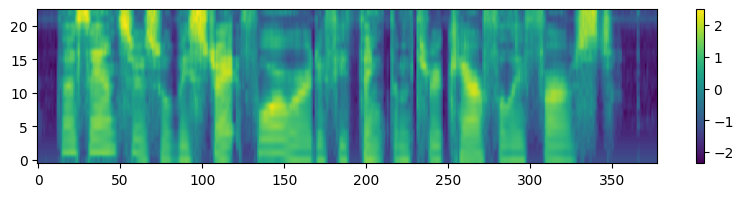

In [4]:
import matplotlib.pyplot as plt
import numpy as np

feature = np.transpose(fbank[:, 0, :].numpy())
plt.clf()
plt.figure(figsize=(10,2))
plt.imshow(feature, aspect='auto', origin='lower')
plt.colorbar()
plt.show()

# CTC model for ASR

## Obtain phoneme output units

In [5]:
# First find the unique phones in train.json, and then
# create a file named vocab.txt, each line in this 
# file is a unique phone, in total there should be 
# 40 lines

vocab = {}
phonemes = []
with open("vocab_39.txt") as f:
    for id, text in enumerate(f):
        vocab[text.strip()] = id
        phonemes.append(text)
phonemes = phonemes[1:]

In [6]:
# Count the number of times each phone appear in the training set
# and save the numbers correcponding to each phone in vocab.txt 
# into counts.txt

# counts = []
# with open("counts.txt") as f:
#     for i in f:
#         counts.append(int(i))

## Plot frequencies of graphemes

In [7]:
# plt.clf()
# plt.figure(figsize=(10,2))
# freq = np.array(counts) / np.sum(counts) * 100
# plt.bar(phonemes, fre
# q)
# plt.show()

## Model & training configurations

In [6]:
from collections import namedtuple
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

args = {'seed': 123,
        'train_json': 'train_fbank.json',
        'val_json': 'dev_fbank.json',
        'test_json': 'test_fbank.json',
        'batch_size': 4,
        'num_layers': 4,
        'fbank_dims': 23,
        'model_dims': 256,
        'concat': 1,
        'lr': 2e-3,
        'vocab': vocab,
        'report_interval': 50,
        'num_epochs': 20,
        'device': device,
       }

args = namedtuple('x', args)(**args)

In [7]:
import models
model = models.BiLSTM_Dropout(
    args.num_layers, args.fbank_dims * args.concat, args.model_dims, len(args.vocab), 0.2)
num_params = sum(p.numel() for p in model.parameters())
print('Total number of model parameters is {}'.format(num_params))



Total number of model parameters is 5326888


## Training

In [10]:
# from datetime import datetime
# from trainer import train
# start = datetime.now()
# model.to(args.device)
# model_path = train(model, args)
# end = datetime.now()
# duration = (end - start).total_seconds()
# print('Training finished in {} minutes.'.format(divmod(duration, 60)[0]))
# print('Model saved to {}'.format(model_path))

## Decoding

In [11]:
### You can uncomment the following line and change model path to the model you want to decode
# model_path="checkpoints/20221110_120418/model_16"

In [8]:
import torch
import models
model_path = '/rds/user/jdb206/hpc-work/MLMI2/exp/checkpoints/20230126_103538/model_14'
print('Loading model from {}'.format(model_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



Loading model from /rds/user/jdb206/hpc-work/MLMI2/exp/checkpoints/20230126_103538/model_14


BiLSTM_Dropout(
  (lstm): LSTM(23, 256, num_layers=4, dropout=0.2, bidirectional=True)
  (drop): Dropout(p=0, inplace=False)
  (proj): Linear(in_features=512, out_features=40, bias=True)
)

In [15]:
from decoder import decode
results = decode(model, args, args.test_json)
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

SUB: 13.75%, DEL: 5.83%, INS: 2.34%, COR: 80.43%, PER: 21.91%


# Generate the Utterance Prediction

In [9]:
fbank_path = '/rds/user/jdb206/hpc-work/MLMI2/exp/fbanks/MDAB0/SX229/fbank.pt'
fbank = torch.load(fbank_path)
fbank_mean = torch.mean(fbank, dim=0, keepdims=True)
fbank_std = torch.std(fbank, dim=0, keepdims=True)
fbank = (fbank - fbank_mean) / fbank_std

with torch.no_grad():
    output = torch.nn.functional.softmax(model(fbank), dim=-1).squeeze()
    # outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)

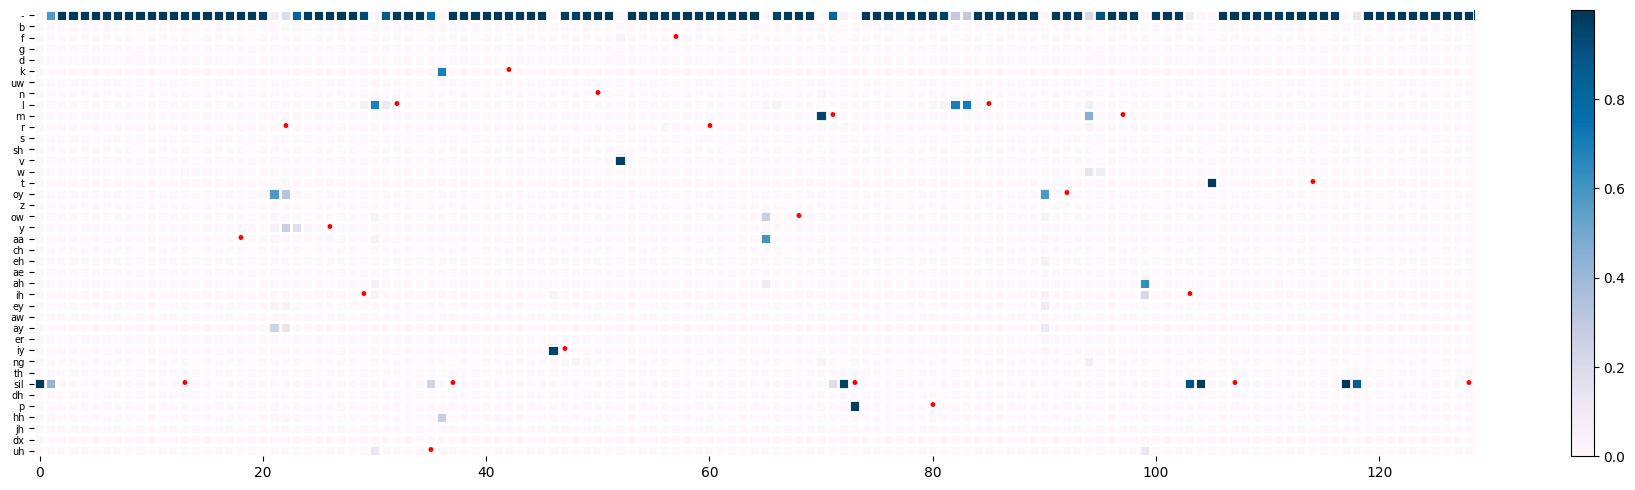

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
# Use imshow to generate heat map
im = ax.imshow(output.detach().numpy().transpose(), cmap='PuBu')

# Set yticks
yticks = [val for val in vocab.keys()]
yticks[0] ='-'
# Change fontsize
for tick in ax.get_yticklabels():
    tick.set_fontsize(7)
ax.spines[:].set_visible(False)
ax.set_yticks(np.arange(0,40,1))
ax.set_yticklabels(yticks)

ax.set_xticks(np.arange(output.shape[0]+1)-.5, minor=True)
ax.set_yticks(np.arange(output.shape[1]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

cbar = fig.colorbar(im)

# Overlay with groundtruth

phns_str = "sil aa r y ih l uh sil k iy n f r ow m sil p l oy m ih sil t sil"
endings_str = "2120 3039 3565 4219 4730 5232 5694 5995 6850 7770 8200 9260 9775 11040 11560 11970 13010 13827 14913 15749 16680 17330 18464 20800"
dur = 1.305625
phns = str.split(phns_str, sep = " ")
phns_mapped = [vocab[i] for i in phns]

endings = str.split(endings_str, sep = " ")
endings = np.array([int(i) for i in endings])

endings = endings / 16000 / dur * output.shape[0]
endings = endings.astype(int)

for idx, x in enumerate(endings):
    # if x >= 100:
    #     break
    y = phns_mapped[idx]
    ax.text(x , y , '•', 
            color = 'r',
            fontsize = '12',
            horizontalalignment='center',
            verticalalignment='center',
            )

# Show plot
fig.tight_layout()
fig.savefig('/rds/user/jdb206/hpc-work/MLMI2/exp/figures/utterance_heatmap.png')
plt.show()

# Blank Penalty

* Goal: Generate a plot of the Insertion %, Deletion %, and PER as a function of the blank penalty
* How: write a new decode function which accepts the penalty (a multiplicative penalty from [0,1])

In [13]:
from utils import concat_inputs
from jiwer import compute_measures, cer

def decode_blank_penalty(model, args, json_file, char=False, penalty = 0):
    idx2grapheme = {y: x for x, y in args.vocab.items()}
    test_loader = get_dataloader(json_file, 1, False)
    stats = [0., 0., 0., 0.]
    for data in test_loader:
        inputs, in_lens, trans, _ = data
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            
            # print(outputs.shape)
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)
            outputs[:,:,0] = outputs[:,:,0] - penalty
            # print(outputs)
            # print(outputs[:,0])
            #APPLY PENALTY HERE
            # outputs[:,0] = outputs[:,0] * (1-penalty)
            # print(outputs[:,0])
            #ASSIGN HARD PREDICTION
            outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
        outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
        outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
        outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
        outputs = [" ".join(i) for i in outputs]
        if char:
            cur_stats = cer(trans, outputs, return_dict=True)
        else:
            cur_stats = compute_measures(trans, outputs)
        stats[0] += cur_stats["substitutions"]
        stats[1] += cur_stats["deletions"]
        stats[2] += cur_stats["insertions"]
        stats[3] += cur_stats["hits"]
        

    total_words = stats[0] + stats[1] + stats[3]
    sub = stats[0] / total_words * 100
    dele = stats[1] / total_words * 100
    ins = stats[2] / total_words * 100
    cor = stats[3] / total_words * 100
    err = (stats[0] + stats[1] + stats[2]) / total_words * 100
    return sub, dele, ins, cor, err

In [59]:
# results_penalty = decode_blank_penalty(model, args, args.test_json, penalty = 0.9)
# print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results_penalty))

SUB: 14.14%, DEL: 1.86%, INS: 10.50%, COR: 84.00%, PER: 26.50%


In [70]:
# penalties = np.arange(0,1.01,0.05)
# penalties[-1] = 0.99
# blank_penalty_data = {}
# for penalty in penalties:
#     res_penalty = decode_blank_penalty(model, args, args.test_json, penalty = penalty)
#     print(res_penalty)
#     blank_penalty_data[penalty] = res_penalty

(13.749478659808148, 5.8251077436396494, 2.3356040595022938, 80.4254135965522, 21.91019046295009)
(13.805088280272487, 5.533157236201863, 2.5163353260114, 80.66175448352566, 21.85458084248575)
(13.805088280272487, 5.408035590157097, 2.6414569720561656, 80.78687612957042, 21.85458084248575)
(13.777283470040317, 5.227304323647991, 2.849993048797442, 80.99541220631168, 21.85458084248575)
(13.832893090504658, 4.990963436674544, 3.072431530654803, 81.1761434728208, 21.896288057834003)
(13.860697900736826, 4.782427359933268, 3.211455581815654, 81.3568747393299, 21.85458084248575)
(13.846795495620743, 4.699012929236758, 3.3921868483247604, 81.4541915751425, 21.93799527318226)
(13.832893090504658, 4.615598498540248, 3.6007229250660364, 81.5515084109551, 22.04921451411094)
(13.860697900736826, 4.448769637147226, 3.892673432503823, 81.69053246211595, 22.202140970387877)
(13.860697900736826, 4.254135965522035, 4.226331155289865, 81.88516613374114, 22.34116502154873)
(13.902405116085081, 4.0455998

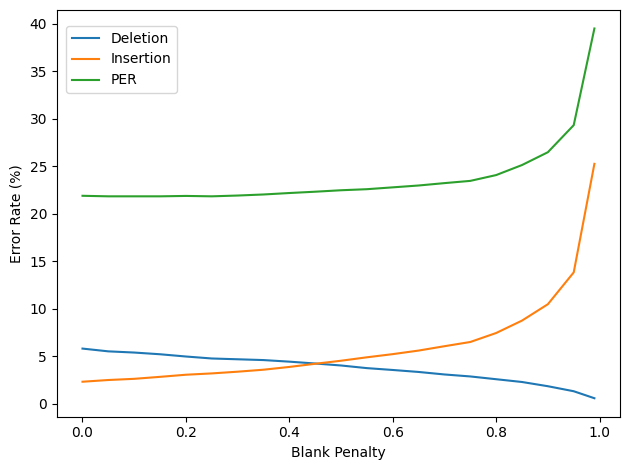

In [107]:
# data = np.array([list(i) for i in blank_penalty_data.values()])

# subs = data[:,0]
# dels = data[:,1]
# ins = data[:,2]
# cors = data[:,3]
# pers = data[:,4]

# fig, ax = plt.subplots()
# ax.plot(penalties, dels, label = "Deletion")
# ax.plot(penalties, ins, label = "Insertion")
# ax.plot(penalties, pers, label = "PER")

# ax.set_xlabel('Blank Penalty')
# ax.set_ylabel('Error Rate (%)')
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))
# fig.tight_layout()
# # fig.savefig('/rds/user/jdb206/hpc-work/MLMI2/exp/figures/blank_penalty.png', dpi = 150)
# plt.show()


# Confusion Matrix

In [131]:
conf_matrix = np.zeros((41,41))
#bottom row is for insertions
#rightmost column is for deletions

import Levenshtein
# def decode_blank_penalty(model, args, json_file, char=False, penalty = 0):
json_file = '/rds/user/jdb206/hpc-work/MLMI2/exp/test_fbank.json'

idx2grapheme = {y: x for x, y in args.vocab.items()}
test_loader = get_dataloader(json_file, 1, False)

counts = np.zeros(41)
for data in test_loader:
    inputs, in_lens, trans, _ = data
    inputs = inputs.to(args.device)
    in_lens = in_lens.to(args.device)
    inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
    with torch.no_grad():
        
        # print(outputs.shape)
        outputs = torch.nn.functional.softmax(model(inputs), dim=-1)
        outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
    outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
    outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
    outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
    outputs = [" ".join(i) for i in outputs]

    trans_unpacked = str.split(trans[0],sep = " ")
    outputs_unpacked = str.split(outputs[0], sep = " ")
    edits = Levenshtein.editops(trans_unpacked, outputs_unpacked)
    
    for tup in edits:
        op, orig, pred = tup
        # print(op, orig, pred)

        if op == 'replace':
            phoneme_orig = trans_unpacked[orig]
            phoneme_pred = outputs_unpacked[pred]
            orig_num = vocab[phoneme_orig]
            pred_num = vocab[phoneme_pred]

            conf_matrix[orig_num, pred_num] += 1

        elif op == 'insert':
            # print(outputs_unpacked[pred])
            conf_matrix[-1, vocab[outputs_unpacked[pred]]] += 1
        
        elif op == 'delete':
            conf_matrix[vocab[trans_unpacked[orig]], -1] += 1

    for phoneme in trans_unpacked:
        phoneme_num = vocab[phoneme]
        counts[phoneme_num] += 1

    
    
    


In [132]:
for i, val in enumerate(counts):
    if i == 39:
        break
    conf_matrix[i, i] = val - sum(conf_matrix[i,:])


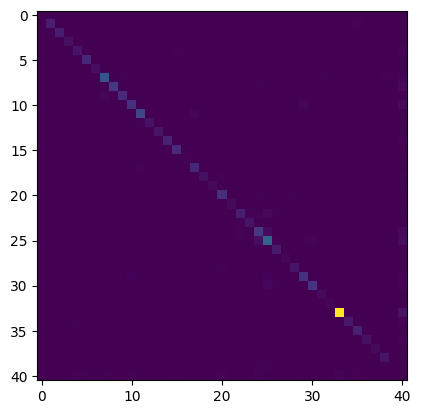

In [133]:
conf_matrix
plt.imshow(conf_matrix)
plt.show()

In [16]:
# !pip install seaborn

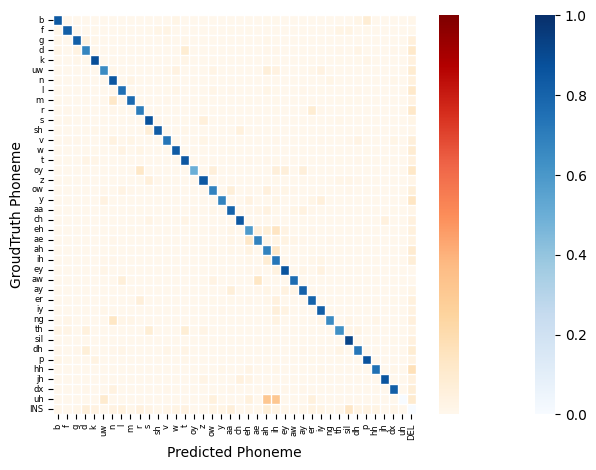

In [141]:
# with np.printoptions(threshold=np.inf):
#     print(conf_matrix)
import seaborn as sns
norm_conf_matrix = conf_matrix[1:, 1:].copy()
for row in range(len(norm_conf_matrix)):
    row_sum = sum(norm_conf_matrix[row,:])
    norm_conf_matrix[row,:] = norm_conf_matrix[row,:] / row_sum

vmin = np.min(norm_conf_matrix)
vmax = np.max(norm_conf_matrix)
off_diag_mask = np.eye(*norm_conf_matrix.shape, dtype=bool)

fig, ax = plt.subplots()
sns.heatmap(norm_conf_matrix, annot=False, mask=~off_diag_mask, cmap='Blues', vmin=0, vmax=1)
sns.heatmap(norm_conf_matrix, annot=False, mask=off_diag_mask, cmap='OrRd', vmin=0, vmax=1, cbar_kws=dict(ticks=[]))
ax.set_xticks(np.arange(norm_conf_matrix.shape[0]+1), minor=True)
ax.set_yticks(np.arange(norm_conf_matrix.shape[1]+1), minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)


yticks = [val for val in vocab.keys()]
yticks = yticks[1:]
yticks.append('INS')
# print(len(yticks))
ax.set_yticks(np.arange(0,40,1) +0.5 )
ax.set_yticklabels(yticks)

ax.set_xticks(np.arange(0,40,1) + 0.5)
xticks = [val for val in vocab.keys()]
xticks = xticks[1:]
xticks.append('DEL')
ax.set_xticklabels(xticks)
ax.tick_params(axis='y', labelsize=6, rotation=0)
ax.tick_params(axis='x', labelsize=6, rotation=90)


ax.set_xlabel('Predicted Phoneme')
ax.set_ylabel('GroudTruth Phoneme')
fig.tight_layout()
fig.savefig('/rds/user/jdb206/hpc-work/MLMI2/exp/figures/confusion_matrix.png', dpi = 200)

In [139]:
conf_matrix[40,:]

array([ 0.,  2.,  0.,  2., 11.,  7.,  0.,  7.,  9.,  2.,  8.,  4.,  1.,
        3.,  5.,  7.,  0.,  0.,  5.,  5., 11.,  0.,  2.,  1., 12.,  5.,
        2.,  0.,  2.,  6.,  5.,  1.,  2., 22.,  5.,  6.,  5.,  0.,  3.,
        0.,  0.])

In [166]:
conf_matrix

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 132.,   0., ...,   0.,   0.,   2.],
       [  0.,   2., 131., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ...,  90.,   0.,   7.],
       [  0.,   0.,   0., ...,   0.,  29.,   2.],
       [  0.,   2.,   0., ...,   3.,   0.,   0.]])

In [112]:
import Levenshtein

In [152]:
trans_unpacked = str.split(trans[0],sep = " ")
print(len(trans_unpacked))
outputs_unpacked = str.split(outputs[0], sep = " ")
Levenshtein.editops(trans_unpacked, outputs_unpacked)

36


[('delete', 3, 3),
 ('replace', 5, 4),
 ('replace', 8, 7),
 ('replace', 9, 8),
 ('replace', 20, 19)]

In [127]:
Levenshtein.editops("a b c", "a b cd")

[('insert', 5, 5)]

# Total Counts in Training Data

In [94]:
import json
with open('/rds/user/jdb206/hpc-work/MLMI2/exp/test_fbank.json', 'r') as f:
    data = json.load(f)

# Iterate over the entries in the JSON object
train_counts = np.zeros(40)
print(len(data))
test_dict = {}
for key, value in data.items():
    # Access an internal element
    print(key)
    unpacked = str.split(value['phn'], sep= " ")

    for phoneme in unpacked:
        phoneme_num = vocab[phoneme]
        train_counts[phoneme_num] += 1
        if phoneme in test_dict.keys():
            test_dict[phoneme] += 1
        else:
            test_dict[phoneme] = 1
print(train_counts)

192
MDAB0_SI1039.WAV
MDAB0_SI1669.WAV
MDAB0_SX49.WAV
MDAB0_SI2299.WAV
MDAB0_SX409.WAV
MDAB0_SX319.WAV
MDAB0_SX139.WAV
MDAB0_SX229.WAV
MWBT0_SX383.WAV
MWBT0_SI1553.WAV
MWBT0_SI2183.WAV
MWBT0_SX203.WAV
MWBT0_SX113.WAV
MWBT0_SI923.WAV
MWBT0_SX23.WAV
MWBT0_SX293.WAV
FELC0_SX126.WAV
FELC0_SI1386.WAV
FELC0_SX216.WAV
FELC0_SX396.WAV
FELC0_SX306.WAV
FELC0_SI2016.WAV
FELC0_SI756.WAV
FELC0_SX36.WAV
MBPM0_SI1577.WAV
MBPM0_SX47.WAV
MBPM0_SI947.WAV
MBPM0_SX227.WAV
MBPM0_SX407.WAV
MBPM0_SX317.WAV
MBPM0_SI1584.WAV
MBPM0_SX137.WAV
MKLT0_SX133.WAV
MKLT0_SX403.WAV
MKLT0_SI1213.WAV
MKLT0_SX43.WAV
MKLT0_SI1843.WAV
MKLT0_SX313.WAV
MKLT0_SI583.WAV
MKLT0_SX223.WAV
FNLP0_SX48.WAV
FNLP0_SI1938.WAV
FNLP0_SI1308.WAV
FNLP0_SX228.WAV
FNLP0_SX408.WAV
FNLP0_SX138.WAV
FNLP0_SI678.WAV
FNLP0_SX318.WAV
MLNT0_SX102.WAV
MLNT0_SX282.WAV
MLNT0_SI642.WAV
MLNT0_SI1902.WAV
MLNT0_SX372.WAV
MLNT0_SX192.WAV
MLNT0_SI1574.WAV
MLNT0_SX12.WAV
MJMP0_SX185.WAV
MJMP0_SX275.WAV
MJMP0_SI1791.WAV
MJMP0_SX95.WAV
MJMP0_SI1535.WAV
MJMP0_SX5.W

In [60]:
import pandas as pd

df = pd.DataFrame(test_dict, index = np.arange(0, 41, 1))
df = df.loc[0,:]

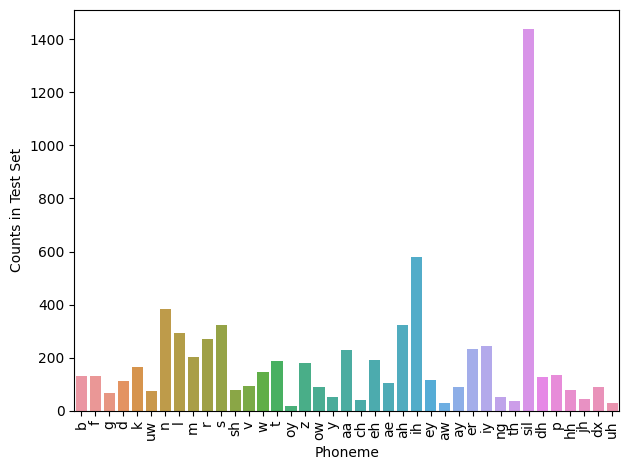

In [95]:
fig, ax = plt.subplots()
sns.barplot(x = [key for key in vocab.keys() if key != '_'], y = [test_dict[key] for key in vocab.keys() if key != '_'])
ax.set_ylabel('Counts in Test Set')
ax.set_xlabel('Phoneme')
ax.tick_params(axis = 'x', rotation = 90)
fig.tight_layout()
fig.savefig('test_counts.png', dpi = 150)
plt.show()

In [66]:
[val for val in test_dict.values()]

[28457,
 2376,
 6158,
 3682,
 2292,
 7526,
 6176,
 4138,
 5376,
 2181,
 11618,
 3948,
 4681,
 2271,
 2215,
 4121,
 2216,
 2432,
 995,
 1952,
 745,
 1220,
 3566,
 3794,
 3277,
 2588,
 1013,
 1191,
 1994,
 1660,
 1466,
 4626,
 1934,
 1864,
 1653,
 500,
 820,
 728,
 304]